In [1]:
import numpy as np
import pandas as pd
import scipy as sc
from scipy.stats import randint,norm,multivariate_normal, ortho_group
from scipy import linalg
from scipy.linalg import subspace_angles,orth
from scipy.optimize import fmin,linear_sum_assignment
from scipy import optimize
from scipy.optimize import minimize
import math
from statistics import mean, stdev ,variance
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import itertools as it
import matplotlib.pyplot as plt
!pip install spams
from google.colab import files
import sys
from cluster.selfrepresentation import ElasticNetSubspaceClustering

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 1.6MB 6.6MB/s 
  Created wheel for spams: filename=spams-2.6.2.5-cp36-cp36m-linux_x86_64.whl size=4514664 sha256=0347a0632c3de4087801d6ba695808df76973cccda8e631ee682462921a508e5
  Stored in directory: /root/.cache/pip/wheels/ba/6f/08/d9d013b9e3ac5ce8f10e67573f38a366c907f99299d5d7711a
Successfully built spams


# 1. Simulation Study, Noiseless case. Simulate data according to the model above with the following parameters:
- n = 2^3,2^4,...,2^10.
- p = 2^4,2^5,2^6,2^ d 7.
- d = 2^(−1)p, 2^(−2)p, 2^(−3)p,2^(−4)p, for each of the values of p.
- K = 4 clusters.
- θ = 10^(−2)θmax, 10^(−1)θmax, θmax, where θmax is the value obtained on average by taking the different subspaces Bi to have uniformly random orientations

In [3]:
#for each subspace K unit vectors in random directions forming a basis
def simulate_orth_basis(p,dim,k):
  b = [orth(np.random.randn(p, dim)) for i in range(k+1)]
  return (b)


#This yields an average pairwise angle denote θmax which depends on the dimensions p and d
def find_theta_max(p,dim):
  theta_max = []
  for i in range(100): 
    rand_subspac1 = orth(np.random.randn(p, dim))
    rand_subspac2 = orth(np.random.randn(p, dim))
    theta_max.append(subspace_angles(rand_subspac1,rand_subspac2).max())  
  max_avg_theta = np.average(theta_max)
  return(max_avg_theta)

#Then, replace each Bi by a linear combination Bi ← αBi + (1 − α)B0 where α ∈ (0, 1) is calibrated to yield average pairwise angle θ
def fix_orth_basis(p,k,dim,theta,b) :
  def find_a_for_theta(a,p=p, dim=dim,theta = theta) :
    temp_theta = []
    for i in range(100): 
      rand_subspac0 = orth(np.random.randn(p, dim))
      rand_subspac1 = orth(np.random.randn(p, dim))
      rand_subspac2 = orth(np.random.randn(p, dim))
      temp_theta.append(subspace_angles(rand_subspac0*(1-a)+rand_subspac1*a,rand_subspac0*(1-a)+rand_subspac2*a).max())
    return (np.average(temp_theta)-theta)
  a= sc.optimize.bisect(find_a_for_theta,0,1)
  B = [b[0]*(1-a)+b[i]*a for i in range(1,k+1)]
  return (B)

# consider the following generative model for the data: zi ∼ U({1, .., K}), wi ∼ N(0, Id), xi|zi, wi ∼ N(Bziwi, σ2Ip) 
def simulate_rand_data(n,p,dim,B,k,theta) :
  z = np.random.randint(0,k,n)  
  w = np.random.multivariate_normal(mean = np.zeros(dim),cov =np.diag(np.ones(dim)),size=n)
  X= np.zeros((n,p))
  for i in range(n):
    X[i,] = np.random.multivariate_normal(mean = np.array(np.dot(np.matrix(w[i,:]),B[z[i]].T)).flatten(),cov = np.diag(0*np.ones(p)))  
  return (n,p,dim,theta,X,z,B)


In [4]:
#data simulation
def final_data_simulation(k) :
  nn = [2 ** j for j in range(3,11)]
  pp = [2 ** j for j in range(4,8)]   
  dd = [2 ** -j for j in range(1,5)] 
  tt = [10 ** -j for j in range(0,3)] 
  df = pd.DataFrame(columns=['n', 'p', 'dim','theta','X','z','B'])
  for p in pp: 
    for d in dd:
      dim = int(d*p)
      b= simulate_orth_basis(p=p,dim=dim,k=k)
      for t in tt :
        theta= find_theta_max(p=p,dim=dim)*t
        if (t==1) :
          a=1
          B = [b[0]*(1-a)+b[i]*a for i in range(1,k+1)]
        else :
          B= fix_orth_basis(p,k,dim,theta,b)
        for n in nn: 
          row=pd.Series(list(simulate_rand_data(n=n,p=p,dim=dim,B=B,k=k,theta=theta)[0:7]),["n","p","dim","theta","X","z","B"])
          df= df.append([row],ignore_index=True)
  return (df)



## **Clustering and subspacing: **
You should pick one of the algorithms above (ENsc) in additon to the naive K-mean

In [5]:
#. After Algorithm (kmean and additional) clustering, which yields cluster identities ˆz1, .., zˆn,we estimate the sub-space of each cluster k by performing PCA on 
#the points in this clusterand keeping the top d components as a basis for Bˆk for k = 1, ..,
def pca_subspace(df,i,dim):
  df_new= df[df['cluster']==i].drop(['cluster'],axis=1)
  pca_components_number = len(df_new)-1 if len(df_new)<dim  else dim #It is possible to get clusters of size smaller than d. you can for a generic cluster of m points, take the
#unique sub-space of dimension m−1 passing through these points, and get a subspace with dimension less than d.
  pca = PCA(n_components=pca_components_number)
  pca.fit_transform(df_new)
  B_kmeans = pca.components_
  return (B_kmeans.T)

# apply cluster algo
def find_subspace(X, k, dim, algo):
    temp_df = pd.DataFrame(X)
    temp_df['cluster'] = algo(n_clusters=k).fit(X).labels_
    # ,algorithm='lasso_lars',gamma=50)  #learn about model parameters
    B = [pca_subspace(temp_df, i, dim) for i in range(k)]
    cluster= temp_df['cluster']
    return (B, cluster)


# **recovery performance**
we seek good agreement between the true subspaces and the recovered subspaces. Since we can at best recover the correct subspaces up to a permutation, we enumerate over all 
possible permutations π ∈ SK, where Sk is the group of permutations over K elements, and take the best.


In [7]:

#The cost measures the angle between the original and estimated sub-spaces,with higher values achieved for smaller angle
def measure_cost_subspace(k,B1,B2): 
  all_per = list(it.permutations(range(k)))
  sum_cos_angles_all_per = np.zeros(len(all_per))
  for l, val in enumerate(all_per):
    for i in range(k) : 
      if B2[val[i]].shape[1]>0 : # handling with empty clusters
        sum_cos_angles_all_per[l]+= (math.cos(subspace_angles(B1[i],B2[val[i]]).max()))**2   
  cost_subspace = sum_cos_angles_all_per.max()
  return (cost_subspace)


  
def measure_cost_cluster(cluster1,cluster2):
  data = {'cluster1': cluster1,'cluster2': cluster2} 
  clusters = pd.DataFrame(data, index=range(len(cluster1)))
  m = -1*np.array(clusters.groupby(['cluster1','cluster2']).size().unstack(fill_value=0))
  indx, per = linear_sum_assignment(m)
  cost_cluster = -m[indx,per].sum()/len(clusters) 
  return (cost_cluster)



In [8]:
def all_process(k): 
    df = final_data_simulation(k)
    kmean_res = df.apply(lambda x: find_subspace(x['X'], k, x['dim'], KMeans), axis=1)
    df['B_kmean'] = [pair[0] for pair in kmean_res]
    df['cluster_kmean']  = [pair[1] for pair in kmean_res]
    ensc_resluts = df.apply(lambda x: find_subspace(x['X'], k, x['dim'],ElasticNetSubspaceClustering), axis=1)
    df['B_ensc'] = [pair[0] for pair in ensc_resluts]
    df['cluster_ensc']  = [pair[1] for pair in ensc_resluts]
    return (df)

In [ ]:
#apply algorithm 
measure_cost_subspace_kmean = pd.DataFrame()
measure_cost_cluster_kmean = pd.DataFrame()
measure_cost_subspace_ensc =  pd.DataFrame()
measure_cost_cluster_ensc =  pd.DataFrame()
k = 4 
for iter in range(1) :
  df = all_process(k)
  df.head()
  measure_cost_subspace_kmean.insert(iter, "", df.apply (lambda x: measure_cost_subspace(k, x['B'], x['B_kmean']), axis=1), True)
  print(measure_cost_subspace_kmean) 
  measure_cost_cluster_kmean.insert(iter, "", df.apply(lambda x: measure_cost_cluster(x['z'], x['cluster_kmean']), axis=1), True)
  print(measure_cost_cluster_kmean) 
  measure_cost_subspace_ensc.insert(iter, "", df.apply(lambda x: measure_cost_subspace(k, x['B'], x['B_ensc']), axis=1), True) 
  print(measure_cost_subspace_ensc) 
  measure_cost_cluster_ensc.insert(iter, "", df.apply(lambda x: measure_cost_cluster(x['z'], x['cluster_ensc']), axis=1), True) 
  print(measure_cost_cluster_ensc)
df['measure_cost_subspace_kmean'] = measure_cost_subspace_kmean.apply(lambda x: mean(x), axis=1)
df['measure_cost_cluster_kmean'] = measure_cost_cluster_kmean.apply(lambda x: mean(x), axis=1)
df['measure_cost_subspace_ensc'] = measure_cost_subspace_ensc.apply(lambda x: mean(x), axis=1)
df['measure_cost_cluster_ensc'] = measure_cost_cluster_ensc.apply(lambda x: mean(x), axis=1)
df['theta_degree'] = df.apply(lambda x: math.degrees(x['theta']), axis=1)
df['t'] = list(np.repeat(np.array([1,1/10,1/100]), [8,8,8],axis=0))*16
df['theta_degree'] = round(df['theta_degree'],2)
df.to_csv('q1_df15.csv')
files.download('q1_df15.csv')
df.head()



In [ ]:
#@title Default title text
if 'google.colab' in sys.modules:
    uploaded = files.upload()
df = pd.read_csv('q1_df12 (1).csv')
df['cluster_kmean']=df['cluster_kmean'].apply(lambda x: x.split('\n'))
df['cluster_ensc']=df['cluster_ensc'].apply(lambda x: x.split('\n'))
df['B_kmean']=df['B_kmean'].apply(lambda x: x.split('\n'))
df['B_ensc']=df['B_ensc'].apply(lambda x: x.split('\n'))


## Visualization of recovery performance
For each of the two recovery performance measures, and for each
value of (p, d), make a heatmap showing performance as function of angle θ and
number of samples n

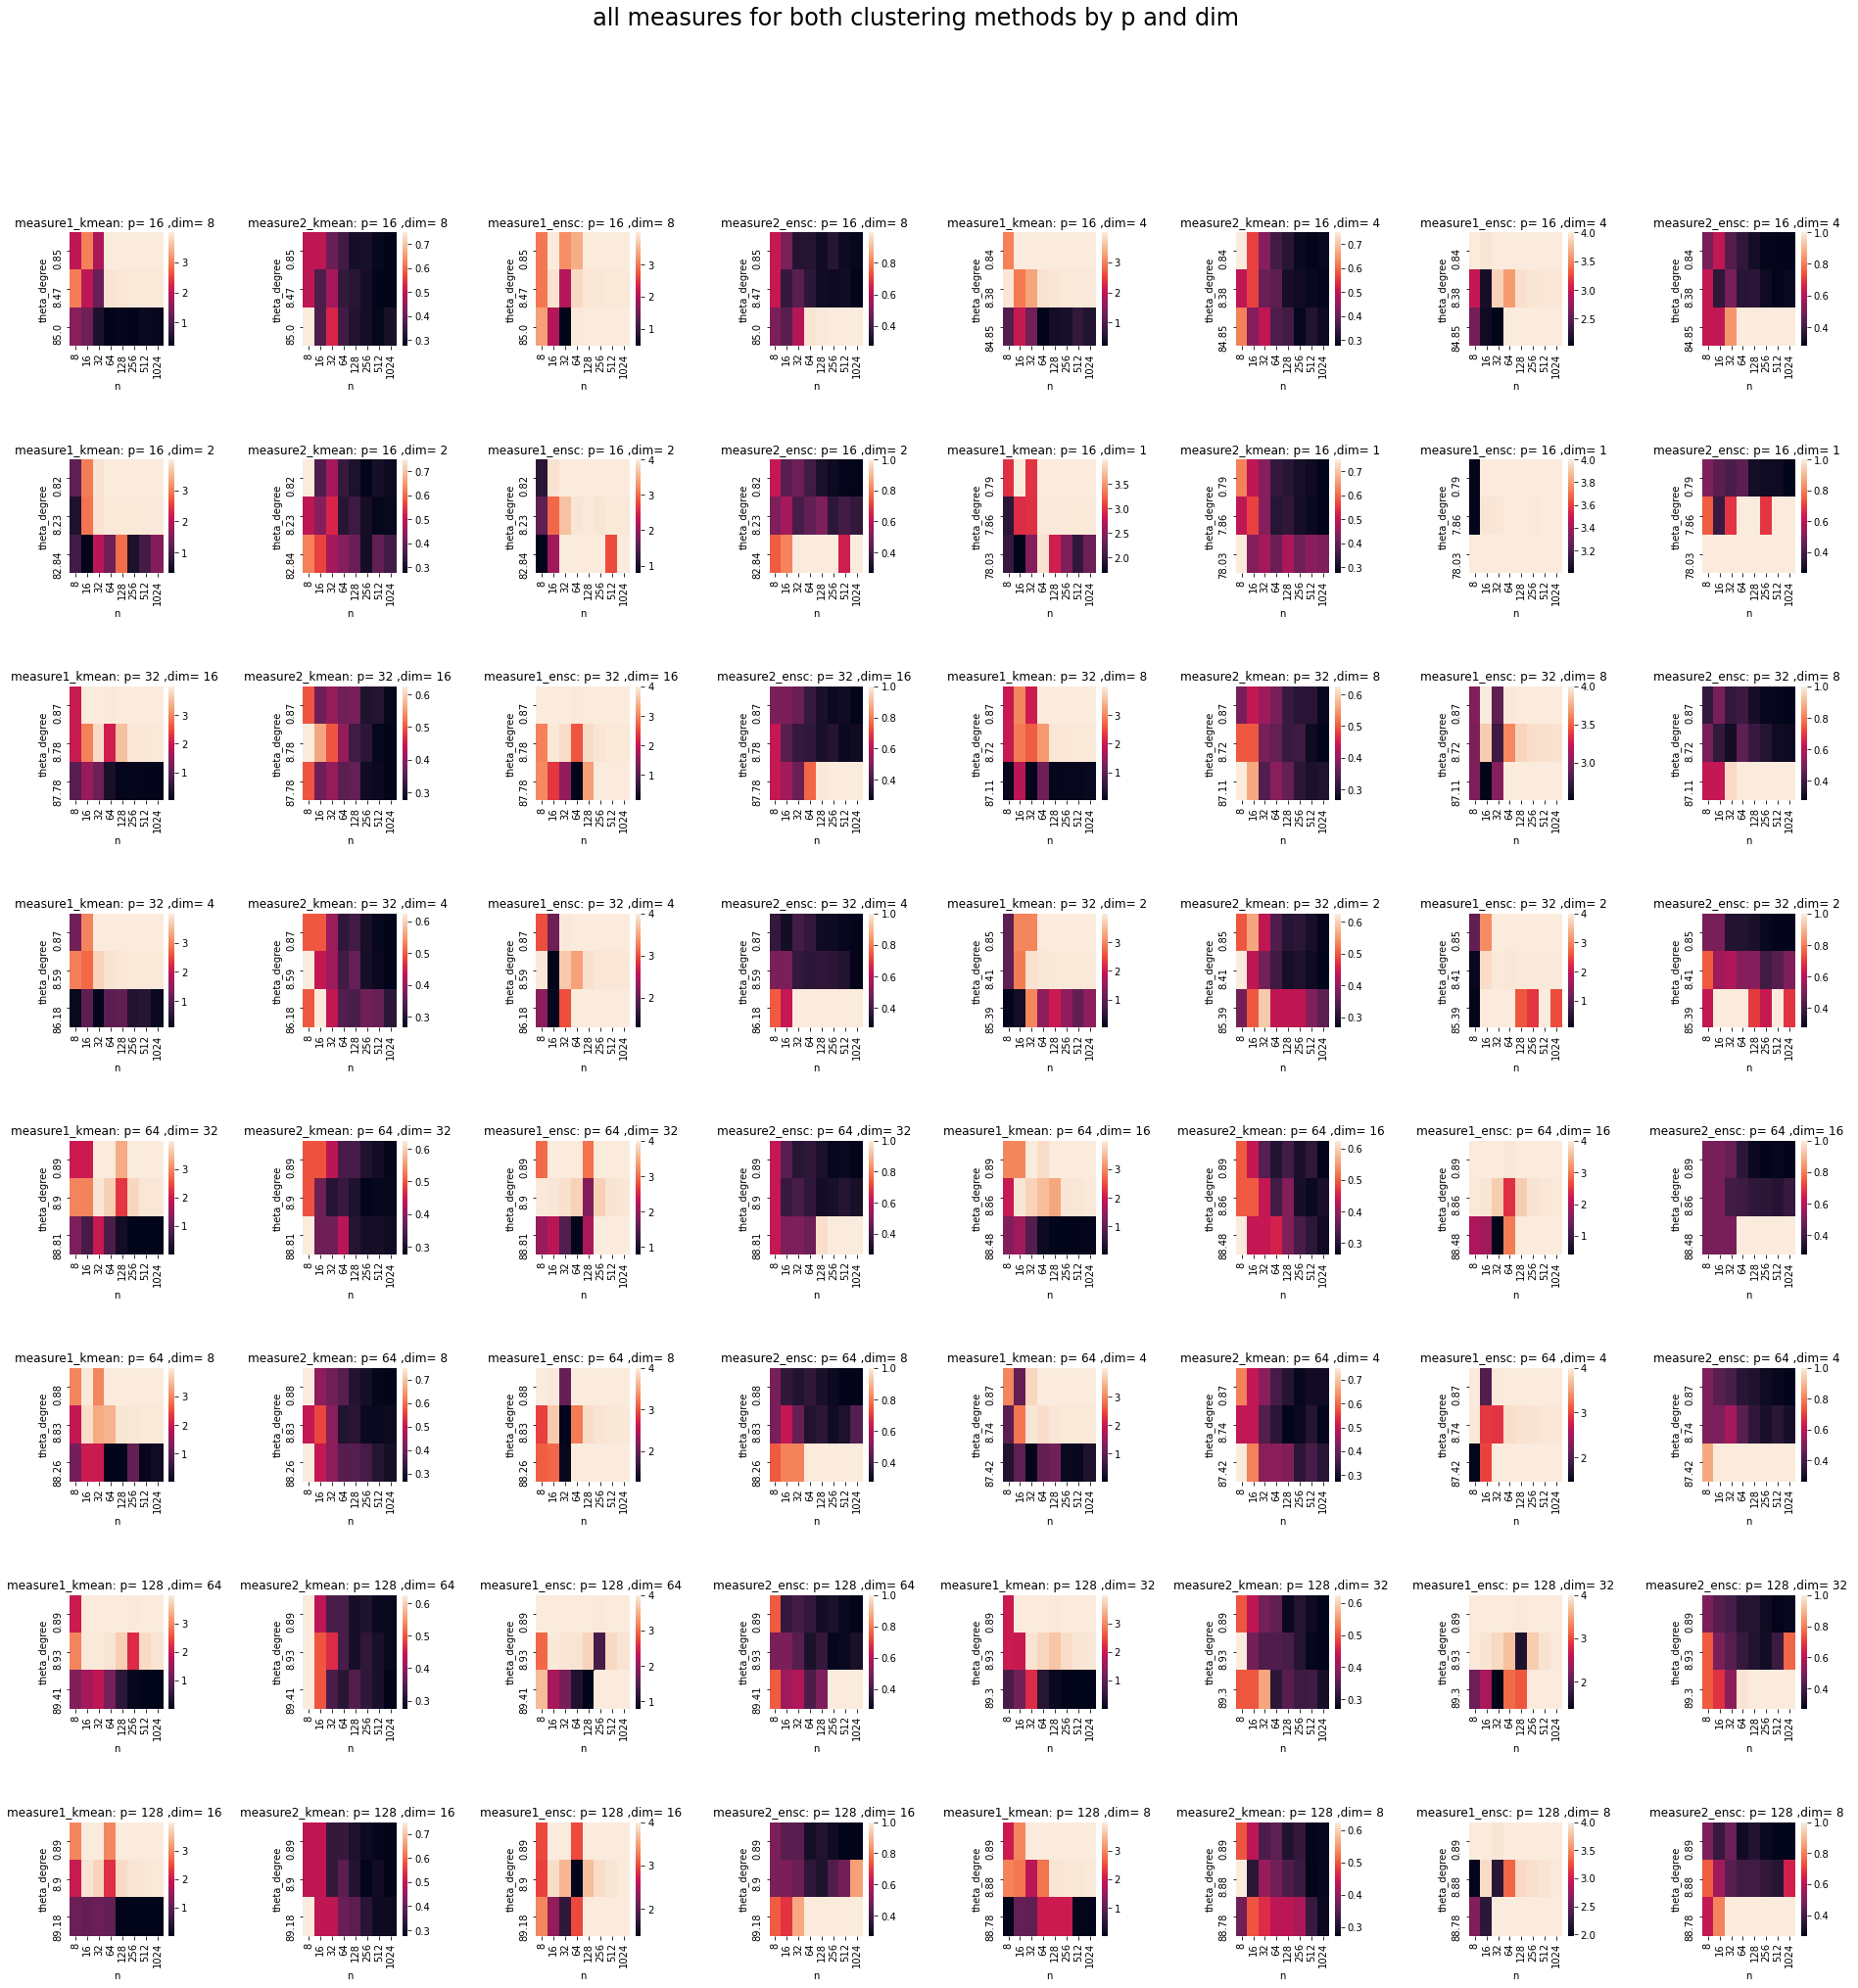

In [59]:
all_measures = ["measure_cost_subspace_kmean","measure_cost_cluster_kmean","measure_cost_subspace_ensc","measure_cost_cluster_ensc"] 
fig, axes  = plt.subplots(8,8,sharex=False, sharey=False,figsize=(32,32))
fig.suptitle('all measures for both clustering methods by p and dim', fontsize=24)
pp = [2 ** j for j in range(4,8)]   
dd = [2 ** -j for j in range(1,5)]
i=0
j=0
for p in pp:
  for d in dd:
    dim = int(d*p)
    for measure in all_measures:
      sns_df = df[(df['p']==p) & (df['dim']==dim)]
      sns_df = sns_df.pivot("theta_degree", "n", measure)
      sns.heatmap(sns_df,ax= axes[i,j])
      plt.subplots_adjust(wspace=1,hspace = 1)
      #counter = counter+1
      axes[i,j].set_title('{a}: p= {b} ,dim= {c} '.format(a=measure,b=p, c=dim), fontsize=12)
      i= i if (j<7) else i+1
      j= j+1 if (j<7) else 0  



average accuracy for data simulated as function of n

In [162]:
def find_accuracy_rate(n,p,dim,theta,k,iter,t):
    accuracy_rate = []
    for r in range(iter):
        b = simulate_orth_basis(p,dim,k)
        if (t==1) :
            a=1
            B = [b[0]*(1-a)+b[i]*a for i in range(1,k+1)]
        else:
            B=fix_orth_basis(p,k,dim,theta,b)
        z = np.random.randint(0,k,n)
        w = np.random.multivariate_normal(mean = np.zeros(dim),cov =np.diag(np.ones(dim)),size=int(n))
        X= np.zeros((n,p))
        for i in range(n):
            X[i,] = np.random.multivariate_normal(mean = np.array(np.dot(np.matrix(w[i,:]),B[z[i]].T)).flatten(),cov = np.diag(0*np.ones(p)))
        ensc_results = find_subspace(X,k,dim,ElasticNetSubspaceClustering)
        ensc_clusters = ensc_results[1]
        accuracy_rate.append(measure_cost_cluster(z,ensc_clusters))
        avg_accuracy_rate = mean(accuracy_rate)
    return (avg_accuracy_rate - 0.5)

Estimate for each such configuration n0.5, i.e. the sample size required to cluster half
the points correctly

In [222]:

def binary_search(low,high,acc,p,dim,theta,k,iter,t): 
  mid = (high + low) // 2
  value = find_accuracy_rate(mid,p,dim,theta,k,iter,t)
  if (value <= acc)  & (value >= -1*acc): 
    return mid 
  elif  value <-acc: 
    return binary_search(low, mid - 1, acc,p,dim,theta,k,iter,t) 
  elif value >acc:
    return binary_search(mid + 1, high, acc,p,dim,theta,k,iter,t) 
  else: 
    return -1

In [ ]:
df2 = df.groupby(['p','dim','theta','t']).size().reset_index()
df2['d\p'] = df2['dim']/df2['p']
df2['n_q'] = np.repeat(0,len(df2))
for row_no in range(len(df2)): 
  p = df2['p'][row_no]
  dim = df2['dim'][row_no]
  t = df2['t'][row_no]
  theta = df2['theta'][row_no]
  df2['n_q'][row_no]= binary_search(8,1024,0.1,p,dim,theta,4,1,t)


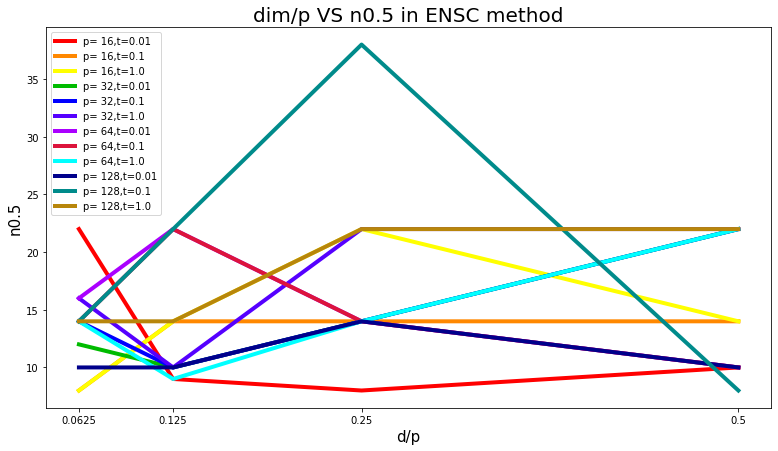

In [119]:
pp =  np.unique(df2['p'])
tt =  np.unique(df2['t'])
plt.figure(figsize=(13,7))
newcolors = ['#F00','#F80','#FF0','#0B0','#00F','#50F','#A0F','#DC143C','#00FFFF', '#00008B','#008B8B','#B8860B']
i=0 
for p in np.unique(df2['p']):
  for t in np.unique(df2['t']):
    plt_df = df2[(df2['p']==p) & (df2['t']==t)]
    plt.plot (plt_df['d\p'],plt_df['n_q'],linewidth=4.0, c=newcolors[i] , label="p= {a},t={b}".format(a=p, b=t))
    i= i+1
    plt.xlabel("d/p",size=15)
    plt.ylabel("n0.5",size=15)
    plt.title("dim/p VS n0.5 in ENSC method",size=20)
    plt.legend(loc='upper left')
    positions = (1/16,1/8,1/4,1/2)
    labels = ("0.0625", "0.125", "0.25","0.5")
    plt.xticks(positions, labels)



 

In [220]:

def find_b_constants(b_cons,df):
  optim_df = pd.DataFrame()
  for p in np.unique(df['p']):
    for t in np.unique(df['t']):
      n1,n2, n3, n4 = df['n_q'][(df['p']==p) & (df['t']==t)]
      row=pd.Series([n1,n2,n3,n4])
      optim_df= optim_df.append([row],ignore_index=False)
  optim_df['b_cons'] = b_cons
  new_df = optim_df.iloc[:,:4].apply(lambda x: (x/optim_df['b_cons'] ),axis=0)
  #return (0 if (new_df.apply(lambda x: len(np.unique(round(x,2)))==1,axis=0)).all() else 1)
  #return new_df.apply(lambda x: len(np.unique(round(x,2)))==1,axis=0).sum()
  return new_df.apply(lambda x: variance(x), axis=0).sum()



In [224]:
#f= minimize(find_b_constants, x0= np.random.randint(df2['n_q'].min(), df2['n_q'].max(), 12) ,args =(df2))
f= minimize(find_b_constants, x0= np.random.uniform(0,1,12) ,args =(df2))
xx=f['x']
xx

array([3.17371513e+02, 1.50601059e+02, 9.20580510e-02, 3.16226471e-01,
       4.43882642e-01, 1.73910633e-01, 3.01830669e-01, 2.20863420e-01,
       5.60098067e-01, 8.80201088e-02, 9.74424700e-01, 1.06663805e-01])

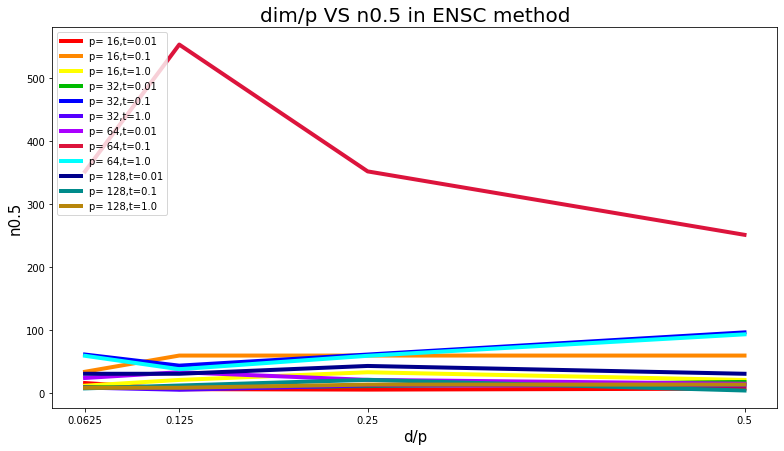

In [219]:
pp =  np.unique(df2['p'])
tt =  np.unique(df2['t'])
plt.figure(figsize=(13,7))
newcolors = ['#F00','#F80','#FF0','#0B0','#00F','#50F','#A0F',    '#DC143C','#00FFFF', '#00008B','#008B8B','#B8860B']

i=0 
for p in np.unique(df2['p']):
  for t in np.unique(df2['t']):
    plt_df = df2[(df2['p']==p) & (df2['t']==t)]
    normalized_n_q = (plt_df['n_q']/xx[i])
    plt.plot (plt_df['d\p'],normalized_n_q,linewidth=4.0, c=newcolors[i] , label="p= {a},t={b}".format(a=p, b=t))

    i= i+1
    plt.xlabel("d/p",size=15)
    plt.ylabel("n0.5",size=15)
    plt.title("dim/p VS n0.5 in ENSC method",size=20)
    plt.legend(loc='upper left')
    positions = (1/16,1/8,1/4,1/2)
    labels = ("0.0625", "0.125", "0.25","0.5")
    plt.xticks(positions, labels)
    